<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preambles" data-toc-modified-id="Preambles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preambles</a></span></li><li><span><a href="#System-parameters" data-toc-modified-id="System-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>System parameters</a></span></li><li><span><a href="#Gate-parameters" data-toc-modified-id="Gate-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gate parameters</a></span></li><li><span><a href="#Optimizing-fidelity-by-changing-the-pulse's-detuning-and-drag-coeff" data-toc-modified-id="Optimizing-fidelity-by-changing-the-pulse's-detuning-and-drag-coeff-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimizing fidelity by changing the pulse's detuning and drag coeff</a></span></li><li><span><a href="#Sweep-gate-time-(optional)" data-toc-modified-id="Sweep-gate-time-(optional)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sweep gate time (optional)</a></span></li><li><span><a href="#Pauli-Transfer-Matrix" data-toc-modified-id="Pauli-Transfer-Matrix-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pauli Transfer Matrix</a></span></li><li><span><a href="#Estimating-error-channel" data-toc-modified-id="Estimating-error-channel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Estimating error channel</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Checking" data-toc-modified-id="Checking-7.0.1"><span class="toc-item-num">7.0.1&nbsp;&nbsp;</span>Checking</a></span></li></ul></li><li><span><a href="#PTM-to-$\chi$" data-toc-modified-id="PTM-to-$\chi$-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>PTM to $\chi$</a></span></li><li><span><a href="#PTM-to-operator" data-toc-modified-id="PTM-to-operator-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>PTM to operator</a></span></li><li><span><a href="#$\chi$-to-unitary-operator" data-toc-modified-id="$\chi$-to-unitary-operator-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>$\chi$ to unitary operator</a></span></li></ul></li></ul></div>

# Preambles

In [18]:
import sys
sys.dont_write_bytecode = True
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
from scipy.optimize import minimize
from qutip import*
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
plt.close('all')

# System parameters

In [24]:
# Biased noise fluxonium
E_L1 = 0.8
E_C1 = 1
E_J1 = 6.8

E_L2 = 1
E_C2 = 1
E_J2 = 7

J_C = 0.2
phi_ext_A = 0.42*2*np.pi
phi_ext_B = 0.42*2*np.pi

# Gate parameters.
T_gate = 50
transition_to_drive = ('11', '21')
# Pulse shape.
shape = 'gauss'  # 'gauss', 'cos' for 1-cos, or 'square'
sigma = 0.25  # sigma in units of T_gate for shape=='gauss'
drag = False
drag_coeff = 0.2

# Scaling of the ideal value given by the inverse matrix element.
drive_amplitude_factor = 1  # 0.95436
# Drive frequency with respect to the resonance.
delta_omega_d = 0

# Method to calculate the propagator.
# 'propagator - full propagator using qt.propagator
# 'sesolve' - propagator using qt.sesolve for 4 computational states
method = 'propagator'

# Hilbert space.
# nlev_cav = 4
nlev_q = 5

save_figure = False
filename_prefix = 'stuff'

# Indices of the computational space.
comp_space = ['00', '01', '10', '11']
interaction = 'on'

# Transitions to show
states011 = ['11', '21', '22']
states010 = ['10', '20']
states001 = ['01', '02']
states000 = ['00']

# Instantiate objects
qubitA = fluxonium.Fluxonium(
    E_L=E_L1, E_C=E_C1, E_J=E_J1, nlev=nlev_q, phi_ext = phi_ext_A)
qubitB = fluxonium.Fluxonium(
    E_L=E_L2, E_C=E_C2, E_J=E_J2, nlev=nlev_q, phi_ext = phi_ext_B)

system =coupobj.CoupledObjects(
    qubitA, qubitB, [qubitA, qubitB, J_C, 'charge'])

# Gate parameters

In [25]:
# Calculate the drive frequency.
level1, level2 = transition_to_drive[0], transition_to_drive[1]
omega_d = abs(system.freq(level1, level2)) + delta_omega_d

# Calculate the drive amplitude.
matr_el = np.abs(system.n_ij(qubitA, level1, level2)
                 + system.n_ij(qubitB, level1, level2))
epsilon = drive_amplitude_factor / abs(matr_el)

print('Detuning between 10-20 and 11-21: {:.1f} MHz'.format(
    1000 * np.abs(system.freq('10', '20') - system.freq('11', '21'))))
print('Transition to drive: {} - {} with frequency {:.4f} GHz'.format(
    level1, level2, abs(system.freq(level1, level2))))
print('Drive frequency: {:.4f} GHz'.format(omega_d))
print('Drive amplitude scale factor: {:.4f}'.format(
    drive_amplitude_factor))

Detuning between 10-20 and 11-21: 68.3 MHz
Transition to drive: 11 - 21 with frequency 4.1121 GHz
Drive frequency: 4.1121 GHz
Drive amplitude scale factor: 1.0000


In [26]:
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

# The time-independent operator part of the drive term.
H_drive = epsilon * (system.n(0) + system.n(1))
H_drive_dummy = 0* (system.n(0) + system.n(1))
if method == 'sesolve':
    # This calculates the evolution operator that works for
    # computational levels only.
    U_t = gates.evolution_compspace_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d,interaction=interaction)

elif method == 'propagator':
    # This calculates the evolution operator for the whole system  
    U_t = gates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    U_nothing = gates.evolution_operator_microwave(-system.H(), H_drive_dummy, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)

In [11]:
U_real = gates.change_operator_proj_subspace(
        system, U_t, subspace=comp_space, interaction=interaction)
single_qubit_gates = gates.operator_single_qub_z(system, U_real[-1])
fidelity = gates.fidelity_cz_gate(
    system, U_t, comp_space=comp_space,
    interaction=interaction, single_gates='z')
#Note: this is only for unitary evolution. We shall investigate dephasing errors later.
print('max fidelity during the simulations: ', np.max(fidelity))

print('\n** Final values **')
print('Fidelity: ', fidelity[-1])
print('Diagonal elements of the evolution operator '
      + '(amplitudes and phases with respect to E*t in units of pi)')

max fidelity during the simulations:  0.9920192920116409

** Final values **
Fidelity:  0.9920192920116409
Diagonal elements of the evolution operator (amplitudes and phases with respect to E*t in units of pi)


In [30]:
U_f = U_t[-1]
U_me = {}
for state in comp_space:
    vec = system.eigvec(state, interaction=interaction)
    U_me[state] = U_f.matrix_element(vec.dag(), vec)
for state in comp_space:
    print(state, np.abs(U_me[state]),
          (np.angle(U_me[state]
                    * np.exp(2j * np.pi * system.level(state) * T_gate))) / np.pi)
print('$(\phi_{00} + \phi_{11} - \phi_{01} - \phi_{01})/\pi=$')
print((np.angle(U_me['00']) + np.angle(U_me['11'])
       - np.angle(U_me['01']) - np.angle(U_me['10'])) / np.pi)
phase_accum = (np.angle(U_me['00']) + np.angle(U_me['11'])
               - np.angle(U_me['01']) - np.angle(U_me['10']))
phase_accum = phase_accum / np.pi

initial_state = system.eigvec(transition_to_drive[0])
final_state = system.eigvec(transition_to_drive[1])
P_driven_transition = gates.prob_transition(U_t, initial_state, final_state)

t_2nd_excited = scipy.integrate.trapz(P_driven_transition, t_points)
print('Time spent in the 2nd state for {} - {}: {:.1f} ns'.format(
    transition_to_drive[0], transition_to_drive[1],
    t_2nd_excited))

00 1.000000016381773 0.15310095920972147
01 0.9999781515560712 0.09587519376987466
10 0.9999571701408015 -0.0061394580330057374
11 0.9995704160127278 -0.9912937234944283
$(\phi_{00} + \phi_{11} - \phi_{01} - \phi_{01})/\pi=$
-0.9275511747280182
Time spent in the 2nd state for 11 - 21: 15.1 ns


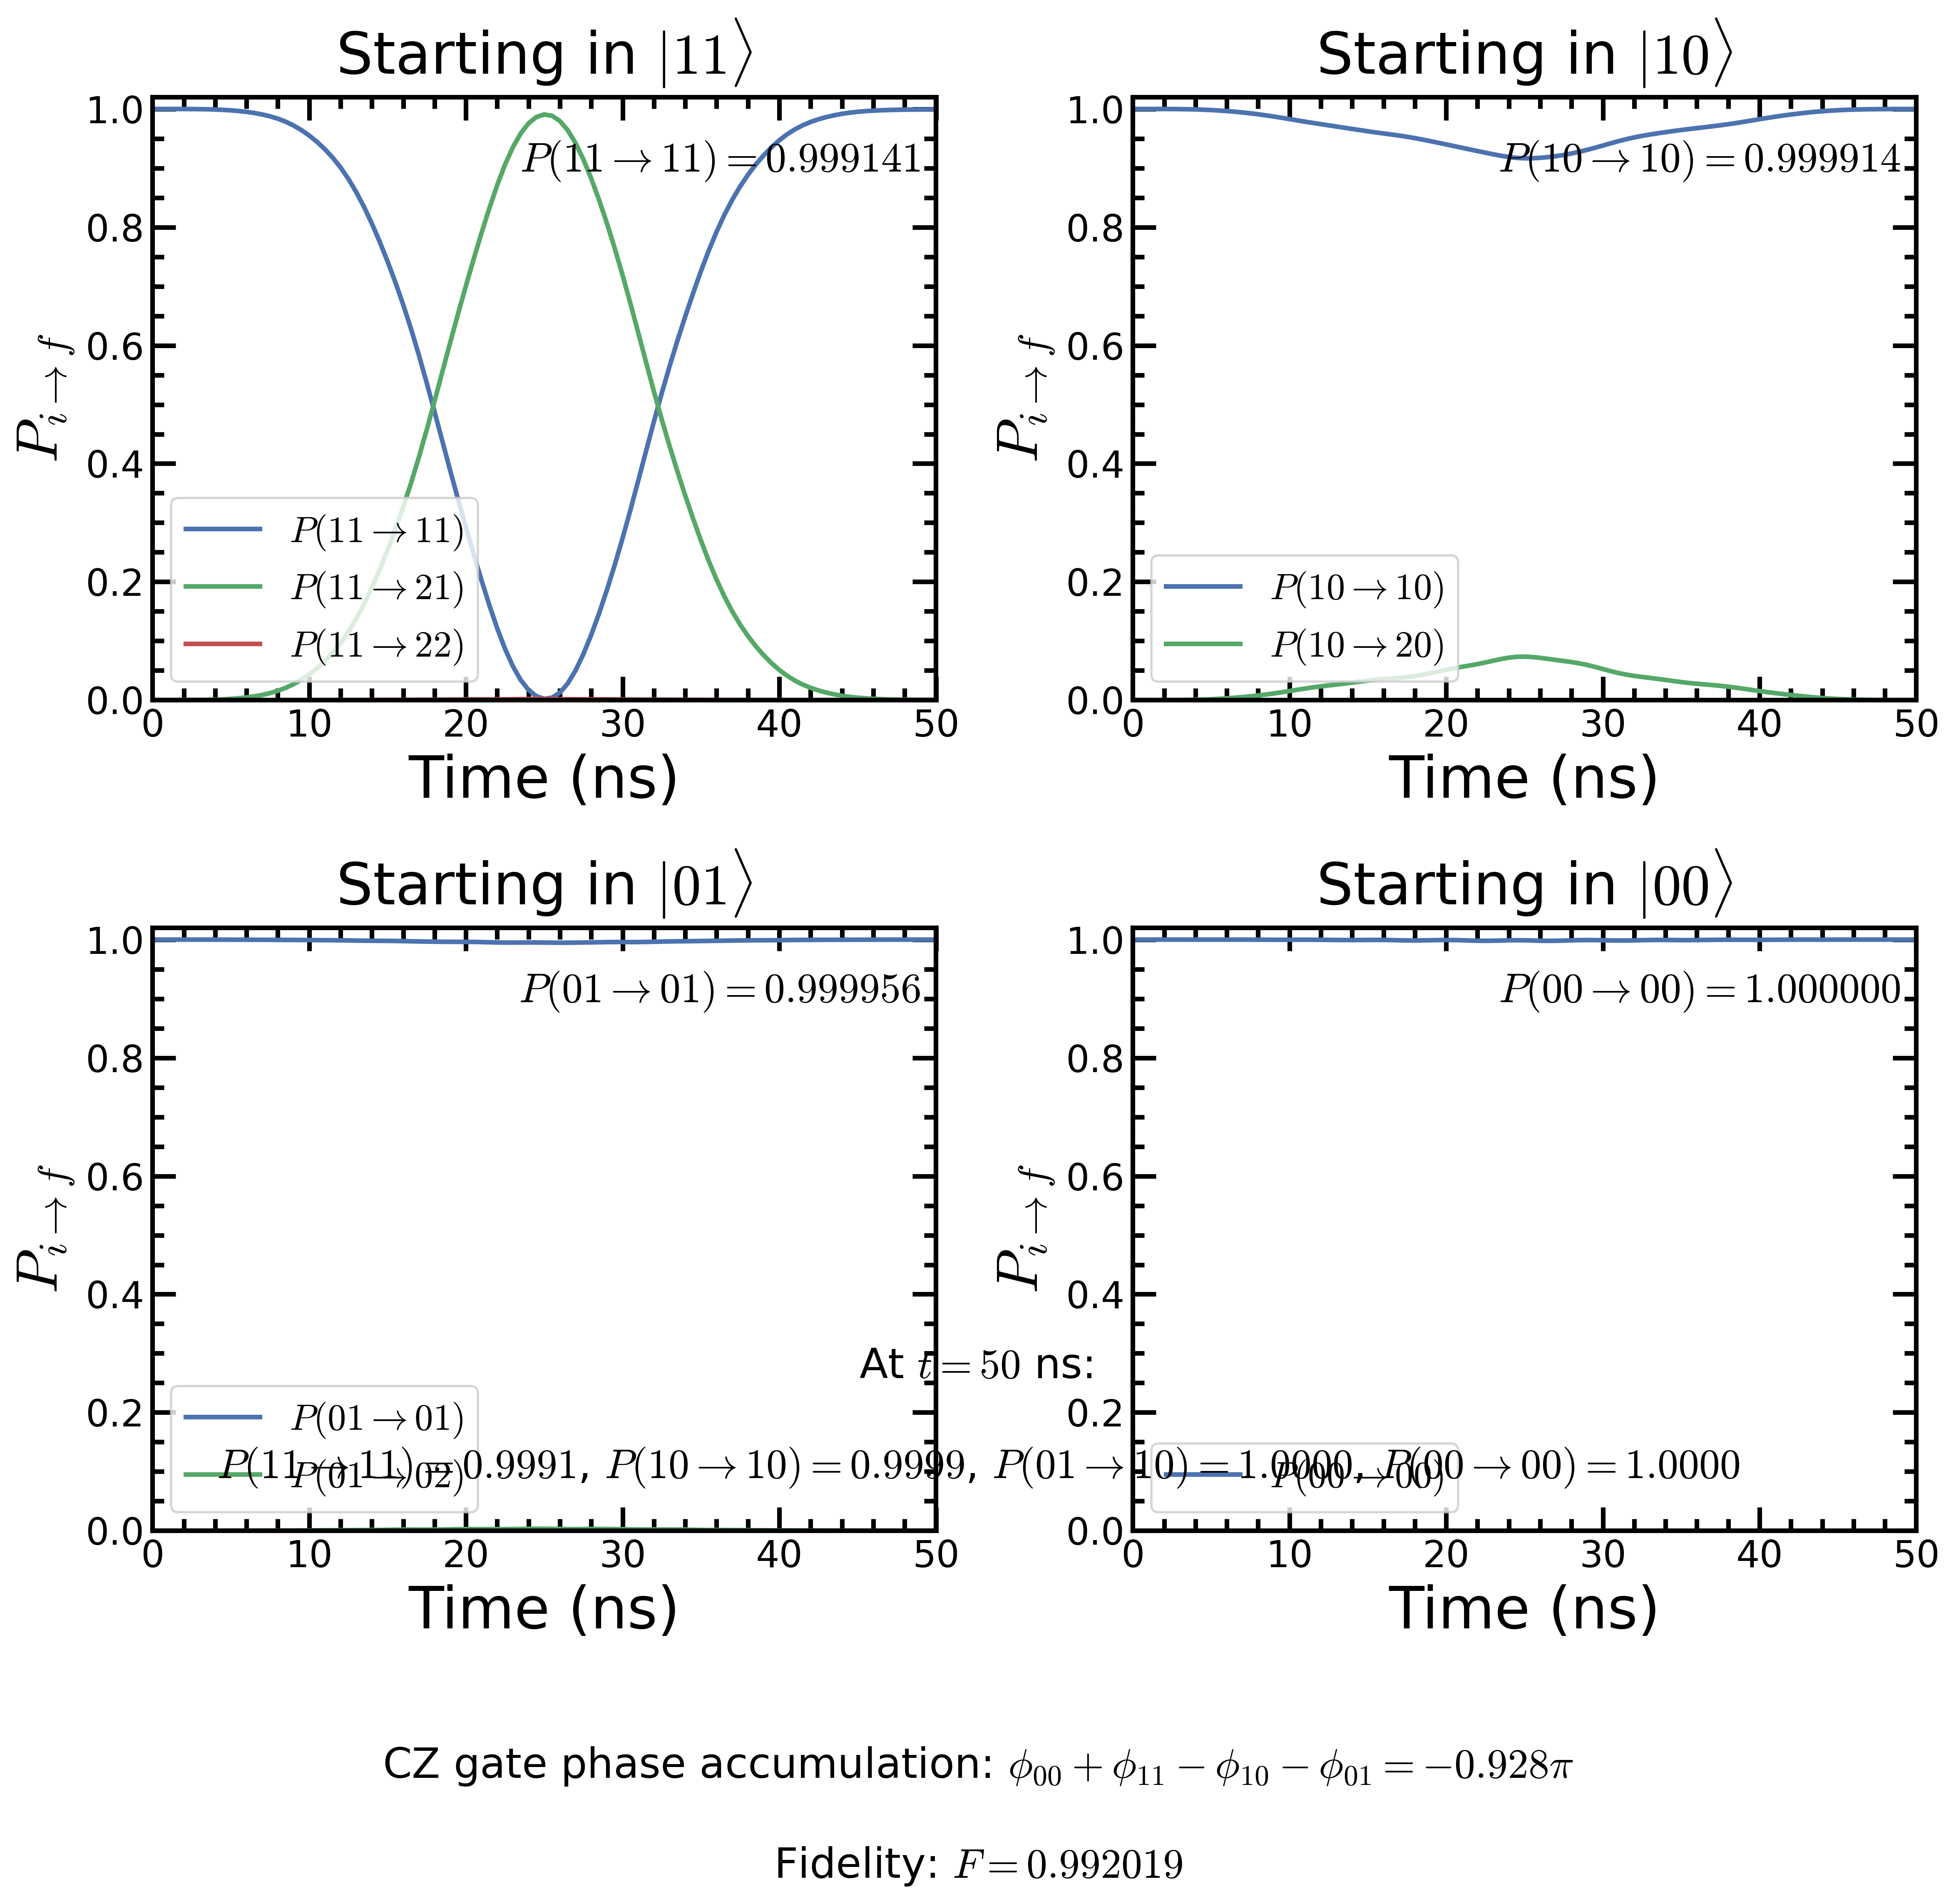

In [31]:
P011 = {}
P010 = {}
P001 = {}
P000 = {}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax011 = axes[0, 0]
ax010 = axes[0, 1]
ax001 = axes[1, 0]
ax000 = axes[1, 1]

for state in states011:
    P011[state] = gates.prob_transition(U_t, system.eigvec('11'), system.eigvec(state))
    ax011.plot(t_points, P011[state], lw=2,
               label=r'$P(11\rightarrow{})$'.format(state))

for state in states010:
    P010[state] = gates.prob_transition(U_t, system.eigvec('10'), system.eigvec(state))
    ax010.plot(t_points, P010[state], lw=2,
               label=r'$P(10\rightarrow {})$'.format(state))

for state in states001:
    P001[state] = gates.prob_transition(U_t, system.eigvec('01'), system.eigvec(state))
    ax001.plot(t_points, P001[state], lw=2,
               label=r'$P(01\rightarrow {})$'.format(state))

for state in states000:
    P000[state] = gates.prob_transition(U_t, system.eigvec('00'), system.eigvec(state))
    ax000.plot(t_points, P000[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))

textfontsize = 18
fig.text(0.5, 0.3, r'At $t = {}$ ns: '.format(int(t_points[-1])),
        fontsize=textfontsize, ha='center')
fig.text(0.5, 0.25,
        r'$P(11\rightarrow 11) = {:.4f}$, '.format(P011['11'][-1])
        + r'$P(10\rightarrow 10) = {:.4f}$, '.format(P010['10'][-1])
        + r'$P(01\rightarrow 10) = {:.4f}$, '.format(P001['01'][-1])
        + r'$P(00\rightarrow 00) = {:.4f}$'.format(P000['00'][-1]),
        fontsize=textfontsize, ha='center')
ax011.text(0.98, 0.93,
           r'$P(11 \rightarrow 11) = {:.6f}$'.format(P011['11'][-1]),
           ha='right', va='top', transform=ax011.transAxes,
           fontsize=textfontsize)
ax010.text(0.98, 0.93,
           r'$P(10 \rightarrow 10) = {:.6f}$'.format(P010['10'][-1]),
           ha='right', va='top', transform=ax010.transAxes,
           fontsize=textfontsize)
ax001.text(0.98, 0.93,
           r'$P(01 \rightarrow 01) = {:.6f}$'.format(P001['01'][-1]),
           ha='right', va='top', transform=ax001.transAxes,
           fontsize=textfontsize)
ax000.text(0.98, 0.93,
           r'$P(00 \rightarrow 00) = {:.6f}$'.format(P000['00'][-1]),
           ha='right', va='top', transform=ax000.transAxes,
           fontsize=textfontsize)
# fig.text(0.65, 0.25, r'$P(10) = {:.4f}$'.format(
#          P010['10'][-1]), fontsize=textfontsize)
fig.text(0.5, 0.1,
         r'CZ gate phase accumulation: '
         + '$\phi_{00} + \phi_{11} - \phi_{10} - \phi_{01} = $'
         + r'${:.3f} \pi $'.format(phase_accum),
         fontsize=textfontsize, ha='center')
fig.text(0.5, 0.05,
         r'Fidelity: '
         + r'$F = {:.6f}$'.format(fidelity[-1]),
         fontsize=textfontsize, ha='center')

for axarr in axes:
    for ax in axarr:
        ax.legend(loc='lower left')
        ax.set_xlim([np.min(t_points), np.max(t_points)])
        ax.set_xlabel('Time (ns)')
        ax.set_ylim([0, 1.02])
        ax.set_ylabel(r'$P_{i\rightarrow f}$')

ax011.set_title(
    r'Starting in $|11\rangle$')
ax010.set_title(
    r'Starting in $|10\rangle$')

ax001.set_title(
    r'Starting in $|01\rangle$')
ax000.set_title(
    r'Starting in $|00\rangle$')

fig.tight_layout(rect=[0, 0.15, 1, 1])

# Optimizing fidelity by changing the pulse's detuning and drag coeff

In [32]:
drag = True

def infidelity(x):
    delta_omega_d, drag_coeff = x
    omega_d = abs(system.freq(level1, level2)) + delta_omega_d
    U_t = gates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
    U_f = U_t[-1]
    return 1-gates.fidelity_cz_gate(system, U_f, comp_space=comp_space,interaction=interaction)

x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
print (xopt.x)
print(1-infidelity(xopt.x))

[-0.00224601 -0.32909674]
0.9998100129351111


In [33]:
delta_omega_d, drag_coeff = xopt.x
omega_d = abs(system.freq(level1, level2)) + delta_omega_d
U_t = gates.evolution_operator_microwave(system.H(), H_drive, comp_space=comp_space, t_points=t_points,T_gate=T_gate, shape=shape, sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, omega_d=omega_d,interaction=interaction)
U_real = gates.change_operator_proj_subspace(
        system, U_t, subspace=comp_space, interaction=interaction)
single_qubit_gates = gates.operator_single_qub_z(system, U_real[-1])
fidelity = gates.fidelity_cz_gate(
    system, U_t, comp_space=comp_space,
    interaction=interaction, single_gates='z')

#Note: this is only for unitary evolution. We shall investigate dephasing errors later.
print('max fidelity during the simulations: ', np.max(fidelity))

print('\n** Final values **')
print('Fidelity: ', fidelity[-1])
print('Diagonal elements of the evolution operator '
      + '(amplitudes and phases with respect to E*t in units of pi)')

max fidelity during the simulations:  0.9998100129351111

** Final values **
Fidelity:  0.9998100129351111
Diagonal elements of the evolution operator (amplitudes and phases with respect to E*t in units of pi)


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax011 = axes[0, 0]
ax010 = axes[0, 1]
ax001 = axes[1, 0]
ax000 = axes[1, 1]

for state in states011:
    P011[state] = gates.prob_transition(U_t, system.eigvec('11'), system.eigvec(state))
    ax011.plot(t_points, P011[state], lw=2,
               label=r'$P(11\rightarrow{})$'.format(state))

for state in states010:
    P010[state] = gates.prob_transition(U_t, system.eigvec('10'), system.eigvec(state))
    ax010.plot(t_points, P010[state], lw=2,
               label=r'$P(10\rightarrow {})$'.format(state))

for state in states001:
    P001[state] = gates.prob_transition(U_t, system.eigvec('01'), system.eigvec(state))
    ax001.plot(t_points, P001[state], lw=2,
               label=r'$P(01\rightarrow {})$'.format(state))

for state in states000:
    P000[state] = gates.prob_transition(U_t, system.eigvec('00'), system.eigvec(state))
    ax000.plot(t_points, P000[state], lw=2,
               label=r'$P(00\rightarrow {})$'.format(state))

textfontsize = 18
fig.text(0.5, 0.3, r'At $t = {}$ ns: '.format(int(t_points[-1])),
        fontsize=textfontsize, ha='center')
fig.text(0.5, 0.25,
        r'$P(11\rightarrow 11) = {:.4f}$, '.format(P011['11'][-1])
        + r'$P(10\rightarrow 10) = {:.4f}$, '.format(P010['10'][-1])
        + r'$P(01\rightarrow 10) = {:.4f}$, '.format(P001['01'][-1])
        + r'$P(00\rightarrow 00) = {:.4f}$'.format(P000['00'][-1]),
        fontsize=textfontsize, ha='center')
ax011.text(0.98, 0.93,
           r'$P(11 \rightarrow 11) = {:.6f}$'.format(P011['11'][-1]),
           ha='right', va='top', transform=ax011.transAxes,
           fontsize=textfontsize)
ax010.text(0.98, 0.93,
           r'$P(10 \rightarrow 10) = {:.6f}$'.format(P010['10'][-1]),
           ha='right', va='top', transform=ax010.transAxes,
           fontsize=textfontsize)
ax001.text(0.98, 0.93,
           r'$P(01 \rightarrow 01) = {:.6f}$'.format(P001['01'][-1]),
           ha='right', va='top', transform=ax001.transAxes,
           fontsize=textfontsize)
ax000.text(0.98, 0.93,
           r'$P(00 \rightarrow 00) = {:.6f}$'.format(P000['00'][-1]),
           ha='right', va='top', transform=ax000.transAxes,
           fontsize=textfontsize)
# fig.text(0.65, 0.25, r'$P(10) = {:.4f}$'.format(
#          P010['10'][-1]), fontsize=textfontsize)
fig.text(0.5, 0.1,
         r'CZ gate phase accumulation: '
         + '$\phi_{00} + \phi_{11} - \phi_{10} - \phi_{01} = $'
         + r'${:.3f} \pi $'.format(phase_accum),
         fontsize=textfontsize, ha='center')
fig.text(0.5, 0.05,
         r'Fidelity: '
         + r'$F = {:.6f}$'.format(1-infidelity(xopt.x)),
         fontsize=textfontsize, ha='center')

for axarr in axes:
    for ax in axarr:
        ax.legend(loc='lower left')
        ax.set_xlim([np.min(t_points), np.max(t_points)])
        ax.set_xlabel('Time (ns)')
        ax.set_ylim([0, 1.02])
        ax.set_ylabel(r'$P_{i\rightarrow f}$')

ax011.set_title(
    r'Starting in $|11\rangle$')
ax010.set_title(
    r'Starting in $|10\rangle$')

ax001.set_title(
    r'Starting in $|01\rangle$')
ax000.set_title(
    r'Starting in $|00\rangle$')

fig.tight_layout(rect=[0, 0.15, 1, 1])

P_driven_transition = gates.prob_transition(U_t, initial_state, final_state)

t_2nd_excited = scipy.integrate.trapz(P_driven_transition, t_points)
print('Time spent in the 2nd state for {} - {}: {:.1f} ns'.format(
    transition_to_drive[0], transition_to_drive[1],
    t_2nd_excited))

Time spent in the 2nd state for 11 - 21: 14.7 ns


# Sweep gate time (optional)

In [11]:
#Gate parameter
T_gate_array = np.linspace(20,100,41) #ns
error_array = np.zeros_like(T_gate_array)
drag_coeff_array = np.zeros_like(T_gate_array)
delta_omega_d_array = np.zeros_like(T_gate_array)

for T_idx, T_gate in enumerate(T_gate_array):
  
    t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
    delta_omega_d = 0
    drag_coeff = 0

    x0 = [delta_omega_d, drag_coeff]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
    
    error_array[T_idx] = infidelity(xopt.x)
    delta_omega_d[T_idx] = xopt.x[0]
    drag_coeff[T_idx] = xopt.x[1]

TypeError: 'int' object does not support item assignment

# Pauli Transfer Matrix

(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feb84683730>)

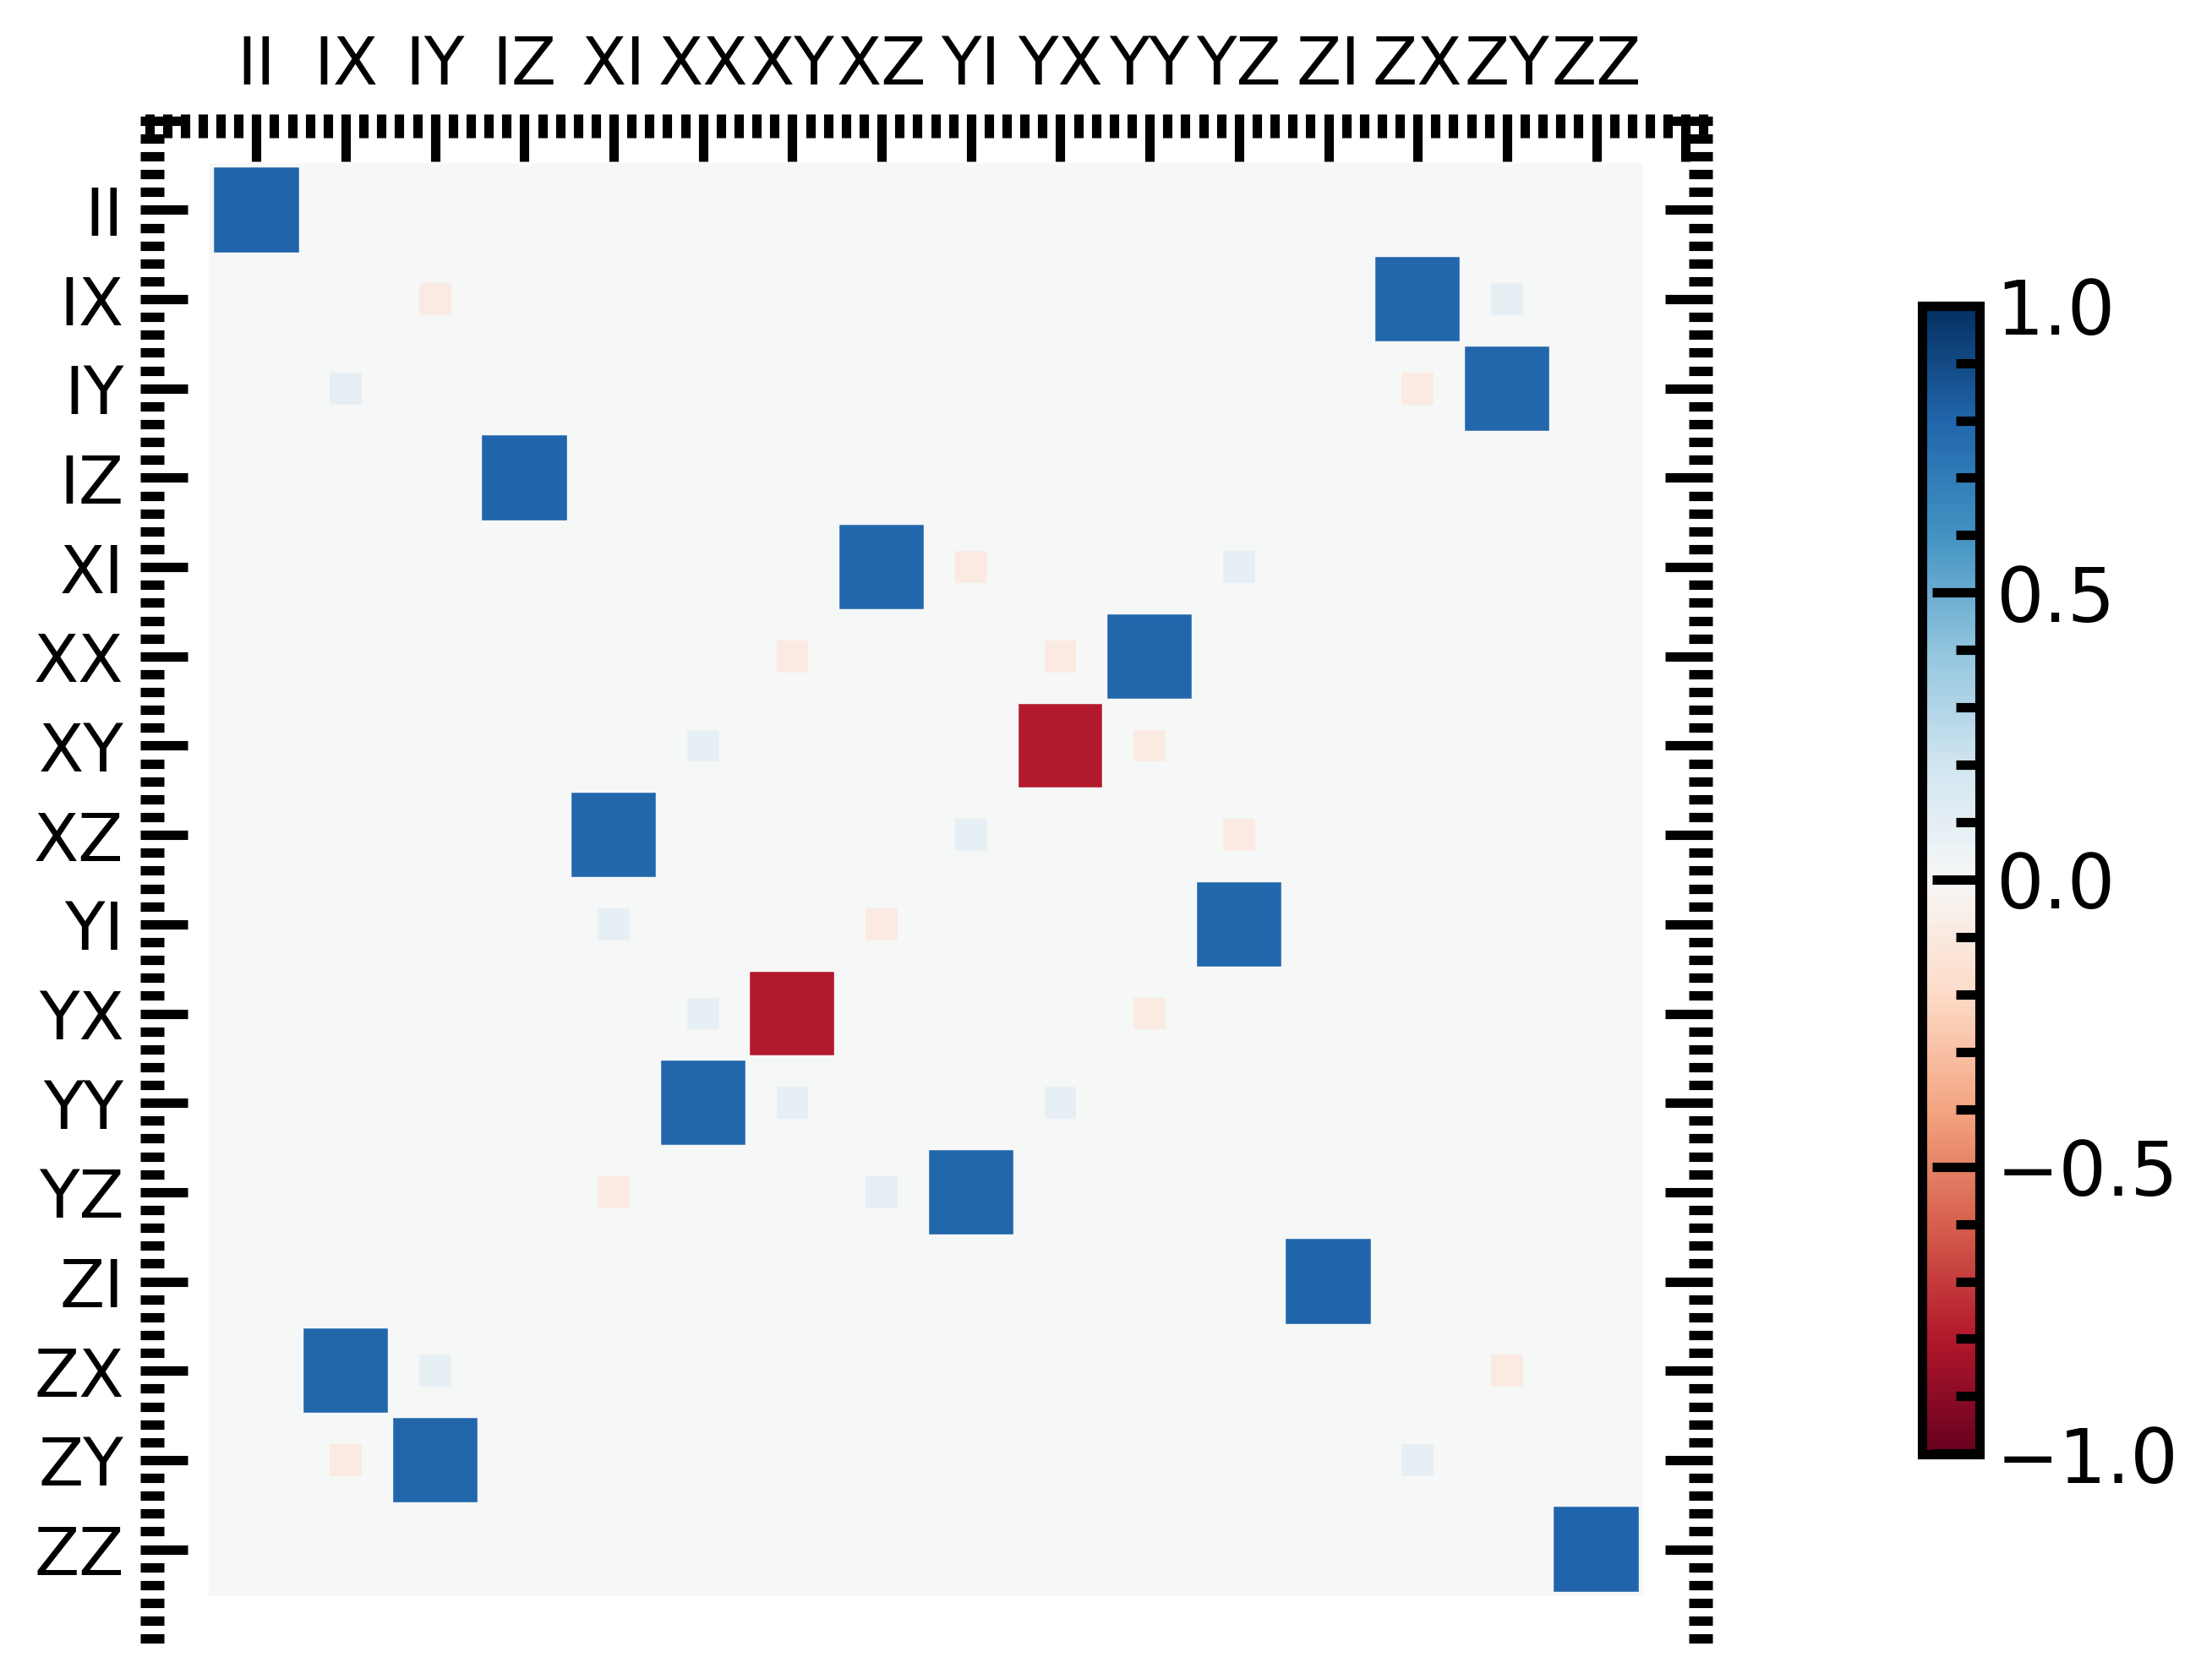

In [27]:
prep_ops = [qeye(nlev_q ), op.sx(phi=np.pi/2, N=nlev_q ), op.sy(phi=-np.pi/2, N=nlev_q ), op.sigx(N=nlev_q )]
meas_ops = [qeye(nlev_q ), op.sigx(N=nlev_q ), op.sigy(N=nlev_q ), op.sigz(N=nlev_q )]
prep_rotations = []
for q1gate in prep_ops:
    for q2gate in prep_ops:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)
meas_rotations = []
for q1gate in meas_ops:
    for q2gate in meas_ops:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
p_in = np.zeros((16,16), dtype = complex)
p_out = np.zeros((16,16), dtype = complex)
# state_0 = tensor(basis(nlev_q,0), basis(nlev_q,0)) 
state_0 = system.eigvec('00')
for i, prep in enumerate(prep_rotations):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave(system.H(), H_drive, psi0 = psi_ini, comp_space=comp_space, 
                                                t_points=t_points,T_gate=T_gate, shape=shape, 
                                                sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, 
                                                omega_d=omega_d,interaction=interaction)
    
    for j, meas in enumerate(meas_rotations):
        p_in[i,j] = np.real(expect(meas, psi_ini))
        p_out[i,j] = np.real(expect(meas, single_qubit_gates*evol_states[-1]))
        
ptm_real =  np.linalg.lstsq(p_out, p_in, rcond=None)[0]

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
hinton(ptm_real, xlabels = op_label, ylabels = op_label)  

# Estimating error channel

In [3]:
#List of collapse operators
gamma1_01 = (10e6)**-1.0
gamma2_01 = (1e3)**-1.0
L1_01 = np.sqrt(gamma1_01)*(system.eigvec('00')*system.eigvec('01').dag() + system.eigvec('00')*system.eigvec('10').dag())
L2_01 = np.sqrt(2*gamma2_01)*(system.eigvec('01')*system.eigvec('01').dag() + system.eigvec('10')*system.eigvec('10').dag()+system.eigvec('11')*system.eigvec('11').dag())

gamma1_02 = (50e3)**-1
gamma2_02 = (5e3)**-1
L1_02 = np.sqrt(gamma1_02)*(system.eigvec('00')*system.eigvec('02').dag() + system.eigvec('00')*system.eigvec('20').dag())
L2_02 = np.sqrt(2*gamma2_02)*(system.eigvec('02')*system.eigvec('02').dag() + system.eigvec('20')*system.eigvec('20').dag()+system.eigvec('22')*system.eigvec('22').dag())

gamma1_12 = (800e3)**-1
gamma2_12 = (1e3)**-1
L1_12 = np.sqrt(gamma1_12)*(system.eigvec('10')*system.eigvec('20').dag() + system.eigvec('11')*system.eigvec('21').dag()
                           + system.eigvec('01')*system.eigvec('02').dag() + system.eigvec('11')*system.eigvec('12').dag())
L2_12 = np.sqrt(2*gamma2_12)*(system.eigvec('02')*system.eigvec('02').dag() + system.eigvec('20')*system.eigvec('20').dag()
                              +system.eigvec('12')*system.eigvec('12').dag() + system.eigvec('21')*system.eigvec('21').dag()
                              +system.eigvec('22')*system.eigvec('22').dag())


c_ops = [L1_01,L2_01, L1_02,L2_02, L1_12,L2_12]

In [12]:
prep_ops = [qeye(nlev_q ), op.sx(phi=np.pi/2, N=nlev_q ), op.sy(phi=-np.pi/2, N=nlev_q ), op.sigx(N=nlev_q )]
meas_ops = [qeye(nlev_q ), op.sigx(N=nlev_q ), op.sigy(N=nlev_q ), op.sigz(N=nlev_q )]
prep_rotations = []
for q1gate in prep_ops:
    for q2gate in prep_ops:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)
meas_rotations = []
for q1gate in meas_ops:
    for q2gate in meas_ops:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
p_in_diss = np.zeros((16,16), dtype = complex)
p_out_diss = np.zeros((16,16), dtype = complex)
# state_0 = tensor(basis(nlev_q,0), basis(nlev_q,0))
state_0 = system.eigvec('00')
for i, prep in enumerate(prep_rotations):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(system.H(), H_drive, psi0 = psi_ini, comp_space=comp_space, 
                                                t_points=t_points,T_gate=T_gate, shape=shape, 
                                                sigma=sigma, DRAG = drag, DRAG_coefficient = drag_coeff, 
                                                omega_d=omega_d,interaction=interaction, c_ops = c_ops)
    
    for j, meas in enumerate(meas_rotations):
        p_in_diss[i,j] = np.real(expect(meas, psi_ini))
        p_out_diss[i,j] = np.real(expect(meas, single_qubit_gates*evol_states[-1]*single_qubit_gates.dag()))
         

(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feb9c772d00>)

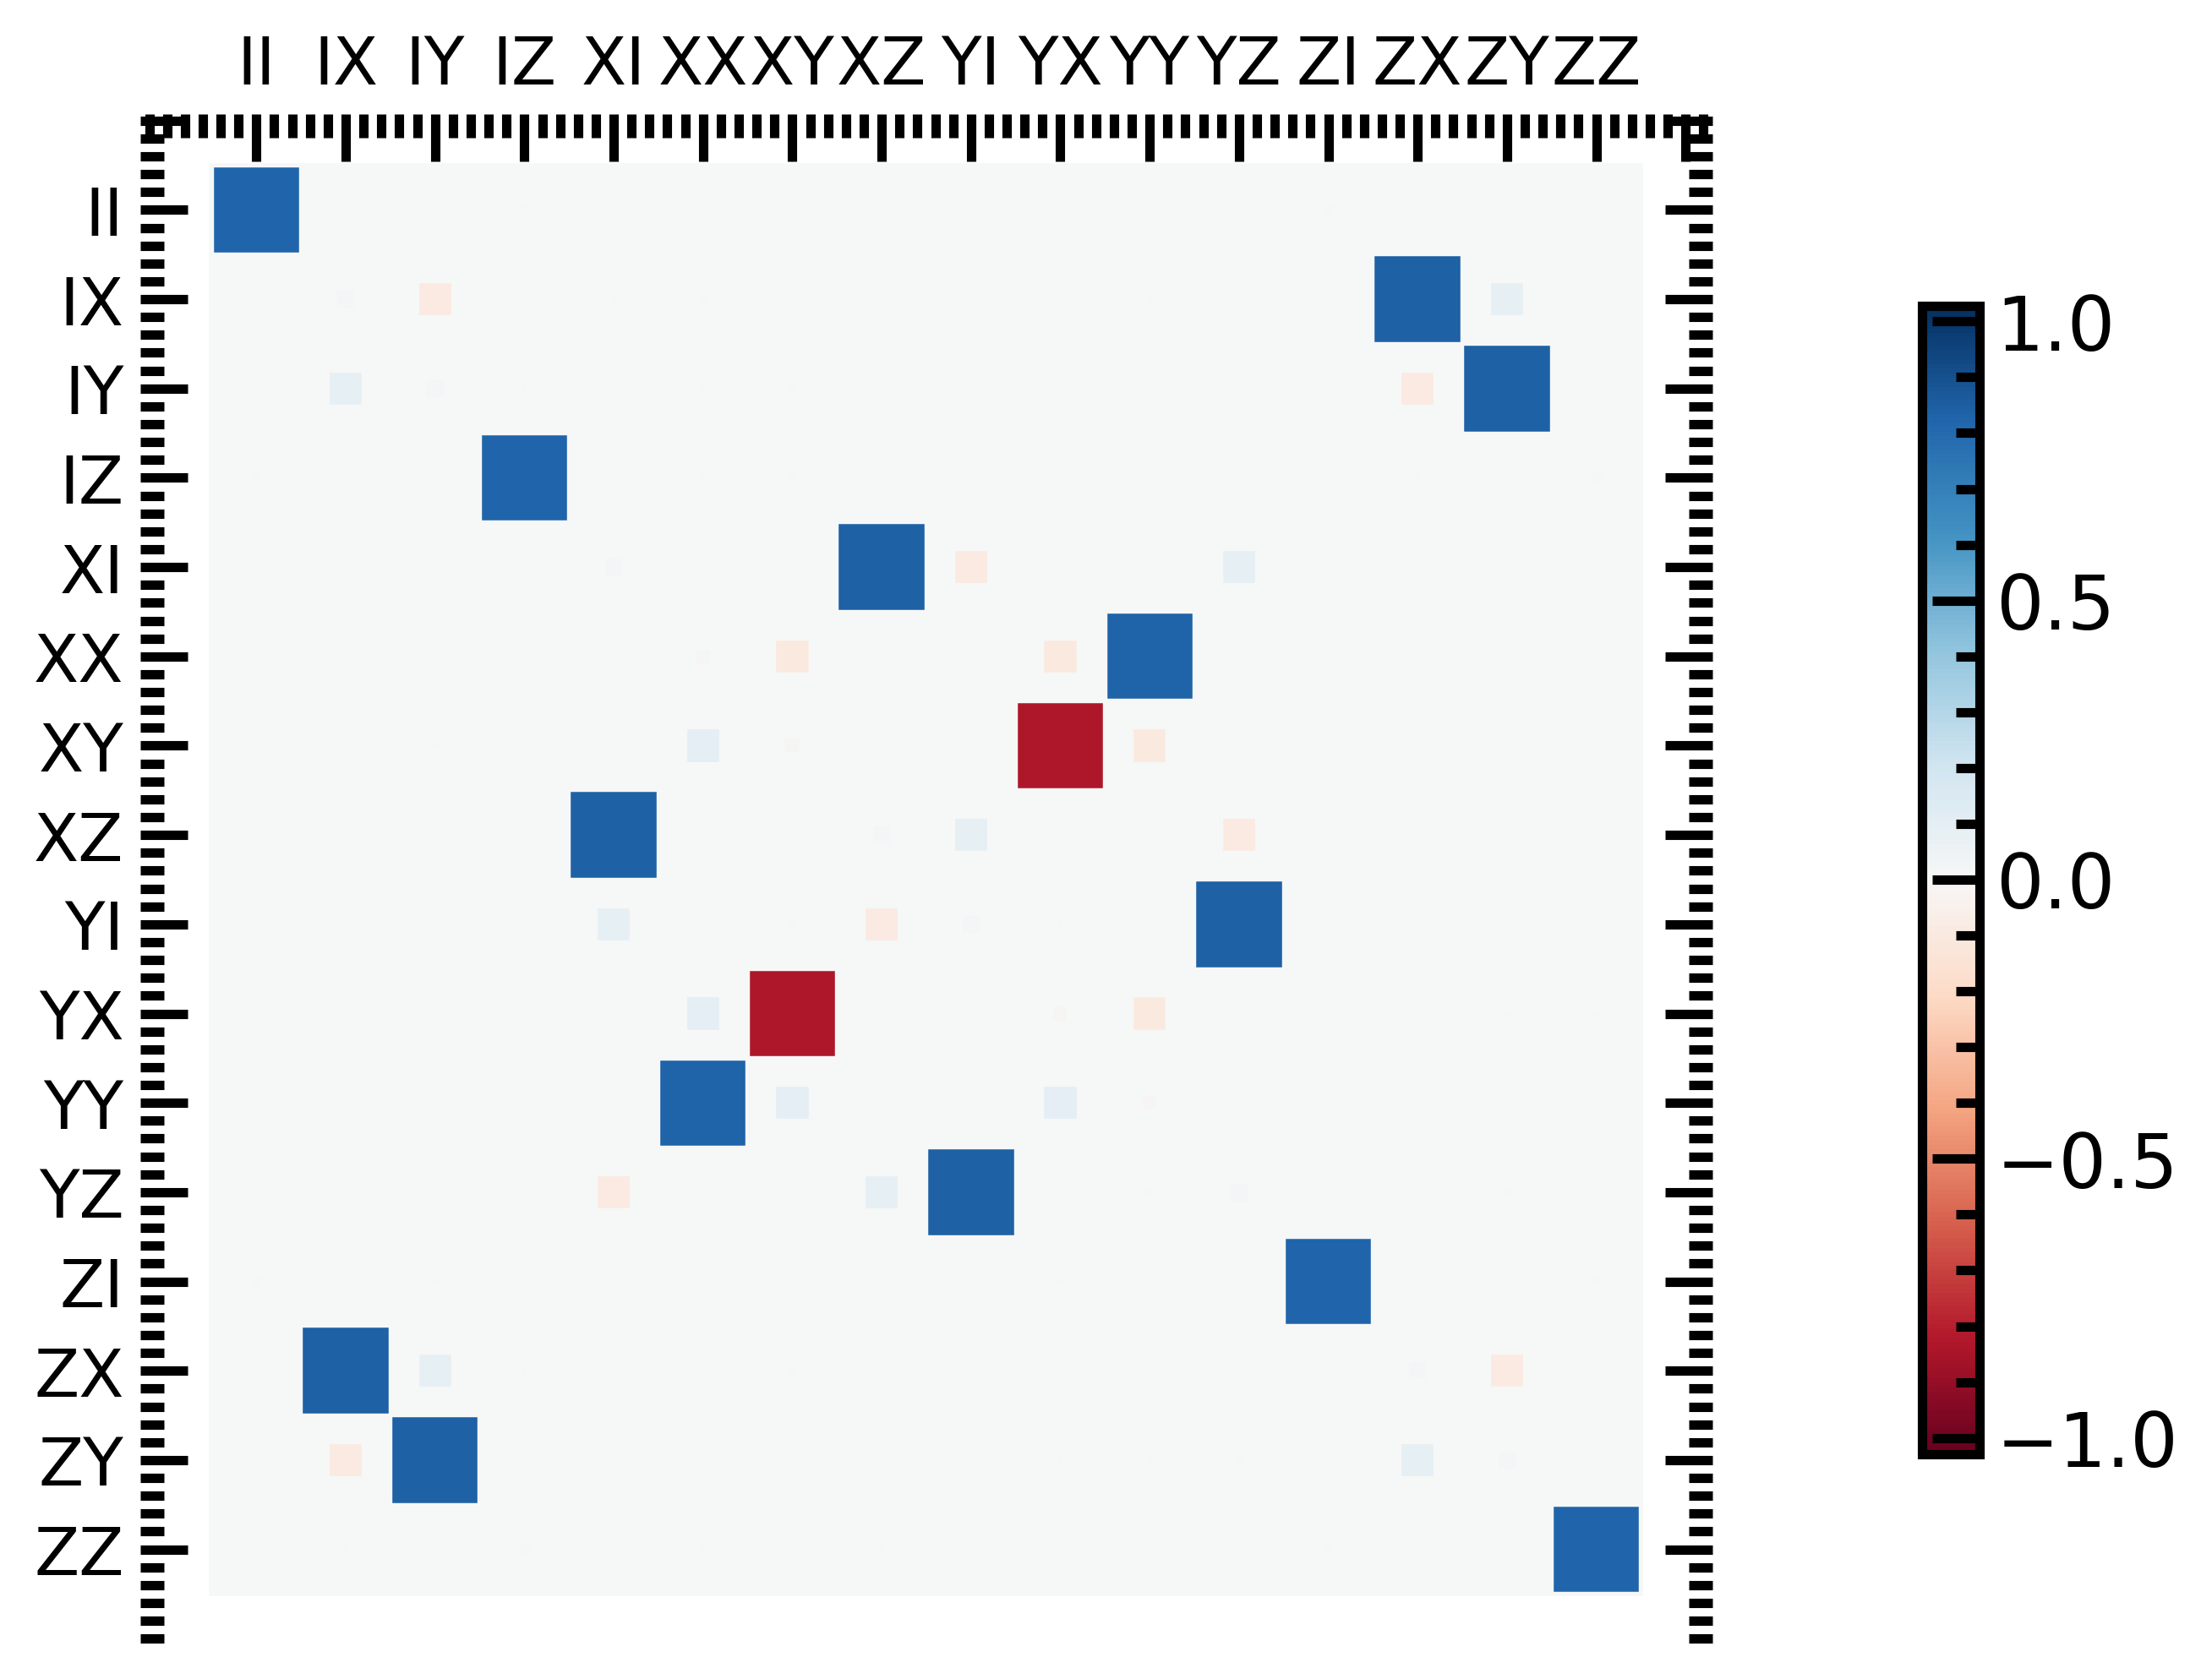

In [13]:
ptm_real_diss =  np.linalg.lstsq(p_out_diss, p_in_diss, rcond=None)[0]

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
hinton(ptm_real_diss, xlabels = op_label, ylabels = op_label) 

In [14]:
print(ptm_real_diss)

[[ 1.00647362e+00+0.j  7.31296209e-06+0.j -1.61571521e-05+0.j
  -3.14492113e-03+0.j -8.58882726e-06+0.j  6.79399296e-06+0.j
  -7.86832689e-06+0.j  1.17151887e-06+0.j  1.48105039e-05+0.j
   6.79633212e-06+0.j  2.71287803e-06+0.j -1.45391539e-05+0.j
  -6.25644012e-03+0.j  1.29479583e-06+0.j  1.62007651e-05+0.j
   2.92882858e-03+0.j]
 [-1.52893675e-05+0.j  2.33707328e-02+0.j  1.15814192e-01+0.j
   5.94490603e-05+0.j -1.46474669e-04+0.j -7.36692187e-05+0.j
   2.70926833e-05+0.j  2.92333970e-06+0.j -3.77928458e-06+0.j
   3.04996660e-05+0.j -2.06030032e-06+0.j -6.76945025e-06+0.j
  -7.31167153e-06+0.j  1.02803420e+00+0.j -1.15793847e-01+0.j
  -1.23659606e-04+0.j]
 [ 7.43611136e-06+0.j -1.16001587e-01+0.j  2.33660073e-02+0.j
  -1.44629712e-05+0.j -2.95523964e-06+0.j -2.48993867e-05+0.j
  -7.46387778e-05+0.j -1.68042047e-05+0.j  1.45395799e-04+0.j
   6.37872650e-06+0.j  2.25793085e-05+0.j  2.99410204e-06+0.j
  -3.73877137e-05+0.j  1.15991547e-01+0.j  1.02804532e+00+0.j
  -1.57100055e-05+0.j]
 

### Checking

<ipython-input-39-e00f614816a0>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
<ipython-input-39-e00f614816a0>:22: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  gate_op = cphase(np.pi)


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e7c3922b0>)

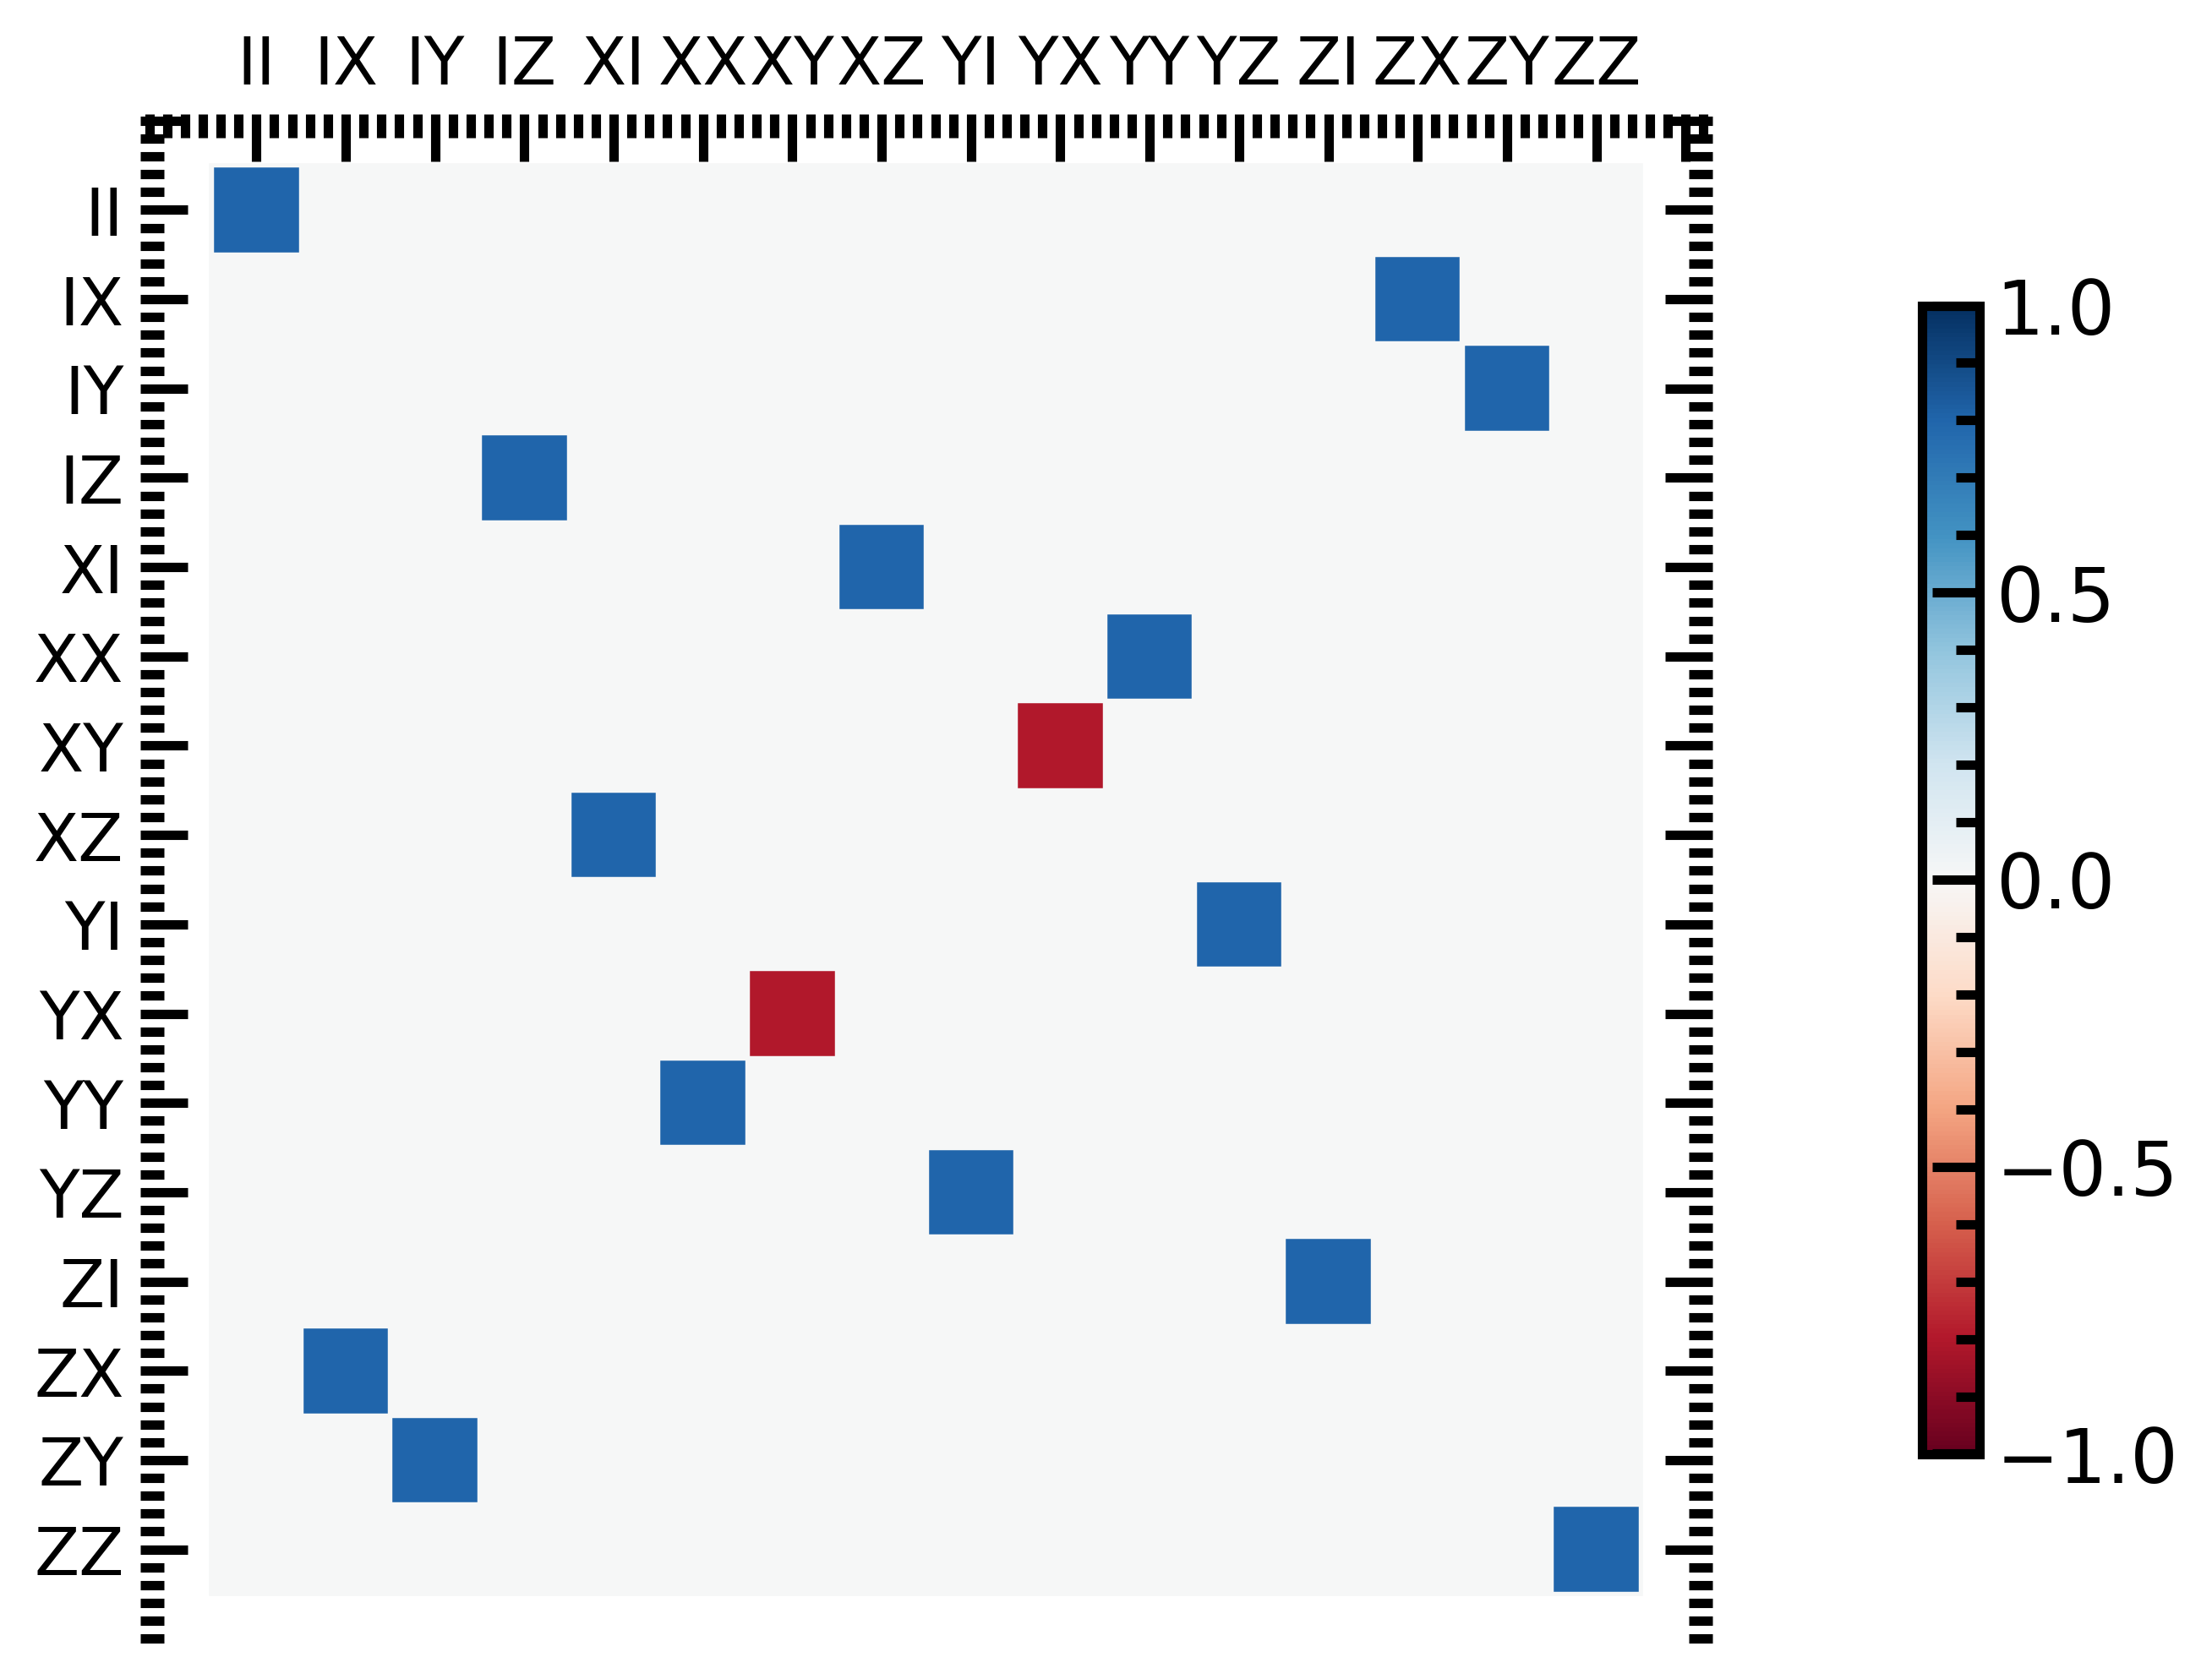

In [39]:
prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16)) 
p_out = np.zeros((16,16)) 

gnd_state = tensor(basis(2,0), basis(2,0))
# gate_op = tensor(qeye(2), rx(np.pi/2))
# gate_op = tensor(rx(np.pi/2), qeye(2))
# gate_op = cnot()
gate_op = cphase(np.pi)
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        p_out[i,j] = expect(rot_j, gate_op*(rot_i*gnd_state))        
ptm_ideal = np.linalg.lstsq(p_in, p_out, rcond = None)[0]
hinton(ptm_ideal, xlabels = op_label, ylabels = op_label) 

(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e7d208f70>)

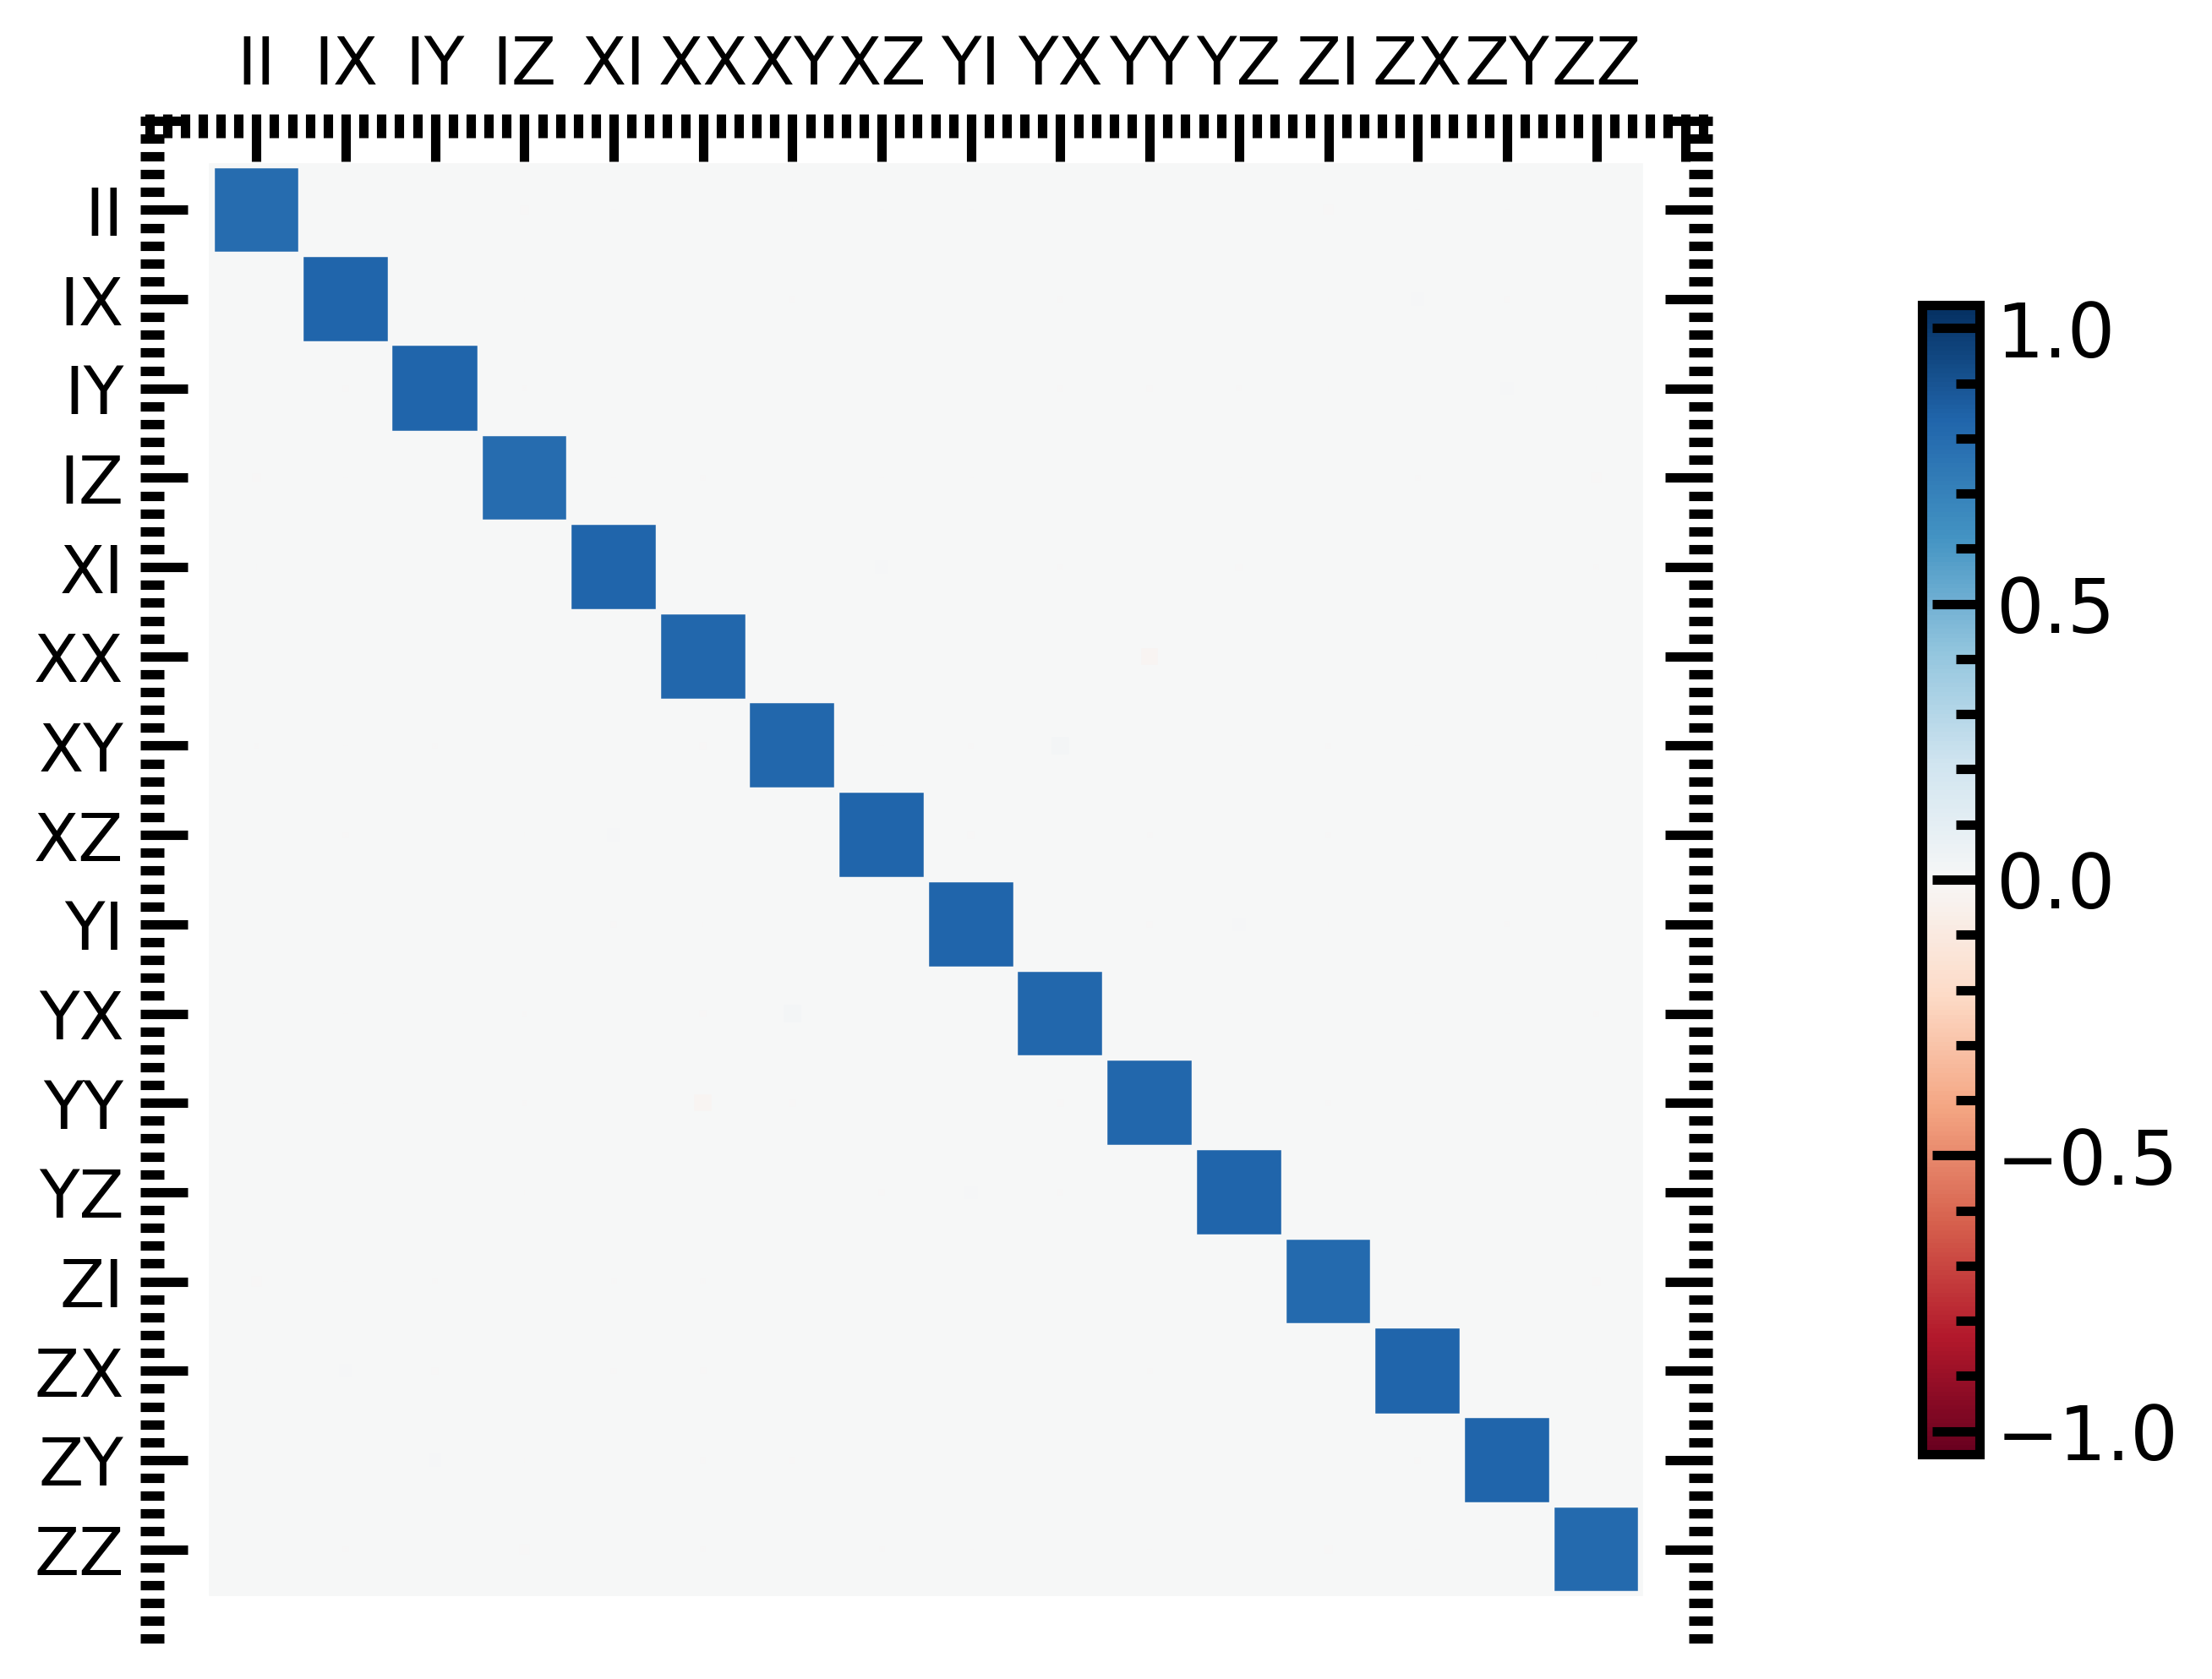

In [53]:
ptm_error = ptm_real_diss*Qobj(np.linalg.inv(ptm_ideal))
hinton(ptm_error, xlabels = op_label, ylabels = op_label) 

## PTM to $\chi$

<ipython-input-58-0ee92852296f>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7feb84c84af0>)

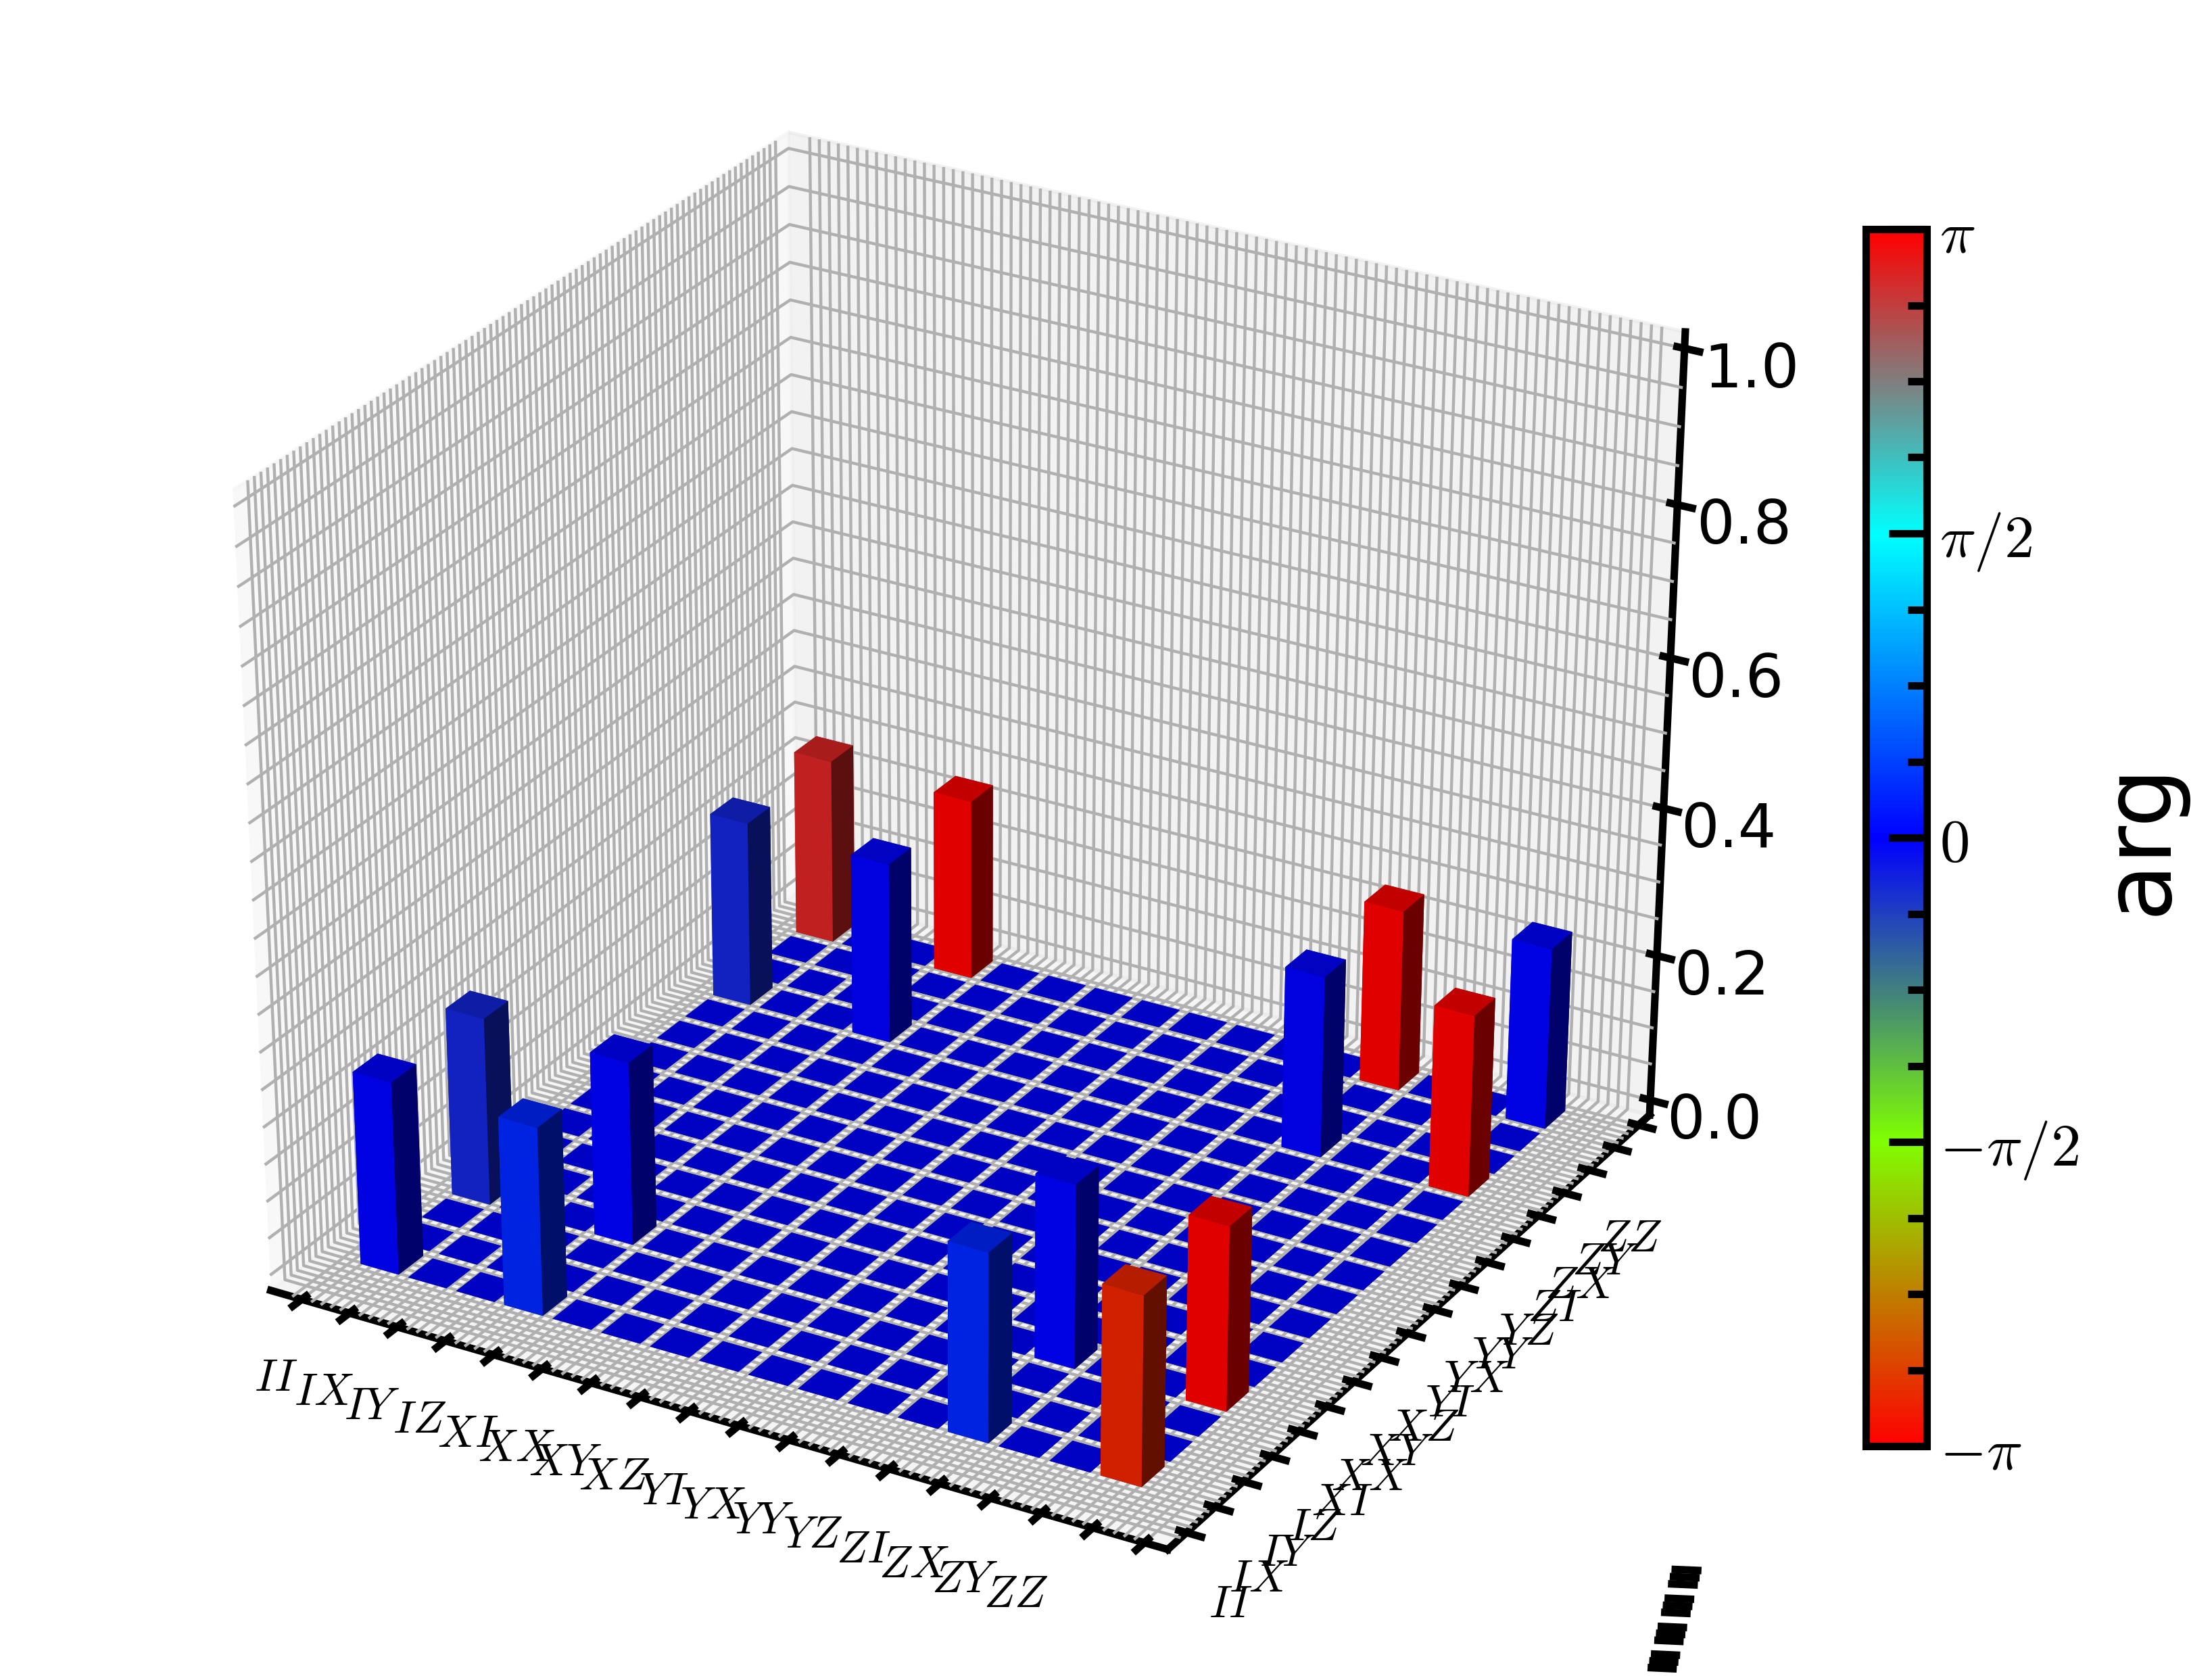

In [58]:
prep_generator = [qeye(2), rx(np.pi/2.0), ry(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16))  
gnd_state = tensor(basis(2,0), basis(2,0))
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        
# Define set of input states
rho_input = []
for i, prep in enumerate(prep_rotations):
    rho = prep*gnd_state
    rho = ket2dm(rho)
    rho_input.append(rho)
    
#Get output states from PTM    
# p_out = p_in@ptm_error
p_out = p_in@ptm_real
rho_output = []
for idx in range (len(rho_input)):
    rho = 0
    for j, meas in enumerate(meas_rotations):
        rho = rho + 0.25*p_out[idx,j]*meas
    rho_output.append(rho)
    
# Quantum process tomography
n = 2
d = 2**n
la = np.zeros(d**4, dtype = complex)
chi = np.zeros(d**4, dtype = complex)
beta = np.zeros((d**4,d**4), dtype = complex)
for j in range(16):
    for k in range(16):
        la[k+16*j] = (rho_output[j]*rho_input[k]).tr()
        for m in range(16):
            for n in range(16):
                 beta[k+16*j, n+16*m] = (meas_rotations[m]*rho_input[j]*meas_rotations[n]*rho_input[k]).tr()

kappa = np.linalg.inv(beta)
chi = kappa.dot(la)
chi = np.reshape(chi, (16,16)).transpose()
# for m in range(4):
#     for n in range(4):
#         for j in range(4):
#             for k in range(4):
#                 chi[n+4*m] = chi[n+4*m]+ kappa[m,n,j,k]*la[j,k]

op_label = [["$I$", "$X$", "$Y$", "$Z$"] for i in range (2)]

qpt_plot_combined(chi, op_label)    

In [42]:
fname = '/Users/longnguyen/Downloads/CZ_chi.txt'
np.savetxt(fname, chi)

In [57]:
print (np.array(abs(chi)))

[[1.02936271e+00 5.13814554e-05 2.09643068e-05 1.98089698e-03
  6.86553050e-05 5.76945432e-06 7.41265464e-05 2.49435423e-05
  1.01103260e-04 7.85259504e-05 7.04585962e-06 7.05420071e-05
  1.13519687e-03 1.69671283e-05 6.85741318e-05 6.83916914e-03]
 [5.13814553e-05 1.46289030e-05 1.95493604e-05 3.21054423e-05
  2.23596858e-06 1.48591381e-05 2.51447546e-07 2.73114596e-06
  3.38759059e-06 1.61458862e-05 2.77284966e-07 2.20500850e-06
  6.51400311e-06 4.47314846e-06 2.58982358e-05 8.25588980e-06]
 [2.09643067e-05 1.95493604e-05 9.62171237e-06 2.44696210e-05
  2.37737277e-06 1.31601102e-06 1.64391995e-05 1.81322373e-06
  1.66328046e-06 1.25595446e-06 1.52621119e-05 2.70896512e-06
  6.80440757e-06 2.48977442e-05 4.70264167e-06 8.88556151e-06]
 [1.98089698e-03 3.21054423e-05 2.44696210e-05 5.40722591e-03
  3.17661479e-05 2.60360205e-06 3.42766155e-06 6.07516417e-05
  3.16709461e-05 1.53867587e-06 2.12443638e-06 5.45623056e-05
  5.44800814e-03 9.31894712e-06 1.01494889e-05 4.24372707e-03]
 [6.

In [58]:
for idx in range(16):
    for idy in range(16):
        if abs(chi[idx,idy]>1e-4):
            print (idx, idy)

0 0
0 3
0 12
0 15
3 0
12 0
15 0


In [60]:
print (abs(chi[0,3])) # IZ
print (abs(chi[0,12])) # ZI
print (abs(chi[0,15])) # ZZ

0.0019808969839587662
0.0011351968665991182
0.006839169135276107


## PTM to operator

In [32]:
from qiskit.quantum_info import Operator, Choi, Kraus, PTM, Chi
from qiskit import visualization
op = Operator(np.array(cphase(np.pi)))
ptm = PTM(op)

# print (ptm)
# ptm = PTM(op)
# print (np.array(ptm)-ptm_ideal_2q)
# print (ptm)
# print (ptm_ideal_2q)
# visualization.plot_state_hinton (ptm)

# cz_uni = ptm.to_operator()
chk = np.array(cz_uni)-np.array(cphase(np.pi))
print (np.round(chk,1))

[[-0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.-0.j]]


<ipython-input-32-0d267afad6ae>:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  op = Operator(np.array(cphase(np.pi)))
<ipython-input-32-0d267afad6ae>:13: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  chk = np.array(cz_uni)-np.array(cphase(np.pi))


## $\chi$ to unitary operator

In [54]:
eig_val, eig_vec = Qobj(chi).eigenstates()

In [55]:
eig_vec[-1]

Quantum object: dims = [[16], [1]], shape = (16, 1), type = ket
Qobj data =
[[-5.09427028e-01+0.00000000e+00j]
 [-3.95957309e-05-2.16741776e-05j]
 [ 1.30853738e-05-3.14153907e-06j]
 [-4.84329877e-01-1.10692672e-01j]
 [ 4.43217907e-05+1.35218017e-05j]
 [ 6.87179191e-05+1.29829475e-05j]
 [ 2.80067009e-06+9.46536122e-08j]
 [-3.50070787e-05-1.82376390e-05j]
 [-5.12019387e-06+5.47292481e-06j]
 [-3.36815926e-06+3.88241961e-07j]
 [-7.34236946e-05-1.12071976e-05j]
 [ 4.98815743e-06+3.47921731e-07j]
 [-4.84322295e-01-1.10696859e-01j]
 [ 3.50705860e-05+1.23218839e-05j]
 [-1.33523573e-05+2.34638247e-07j]
 [ 4.84334858e-01+1.10696220e-01j]]

In [62]:
uni = np.zeros((4,4))

for t in range(16):
    uni = uni + np.array(meas_rotations[t]*np.conjugate(eig_vec[-1][t][0,0]))

In [63]:
np.round(uni,2)

array([[-0.99+0.11j, -0.  +0.j  ,  0.  +0.j  ,  0.  -0.j  ],
       [-0.  +0.j  , -0.99+0.11j, -0.  +0.j  ,  0.  -0.j  ],
       [ 0.  +0.j  , -0.  -0.j  , -0.99+0.11j, -0.  +0.j  ],
       [ 0.  -0.j  ,  0.  -0.j  , -0.  +0.j  ,  0.94-0.33j]])